Andy Chen

Adi Pall-Pareek

Juan F. Atehortúa

DCS 1020
# An Introspective look into the computational tools used in reading at scale

##Background
Tackling the challenge of reading a million books, or any large amount of volumes, is not an easy feat. Many factors come into play regarding how exactly this is to be done and which million books should one choose to read. The key lies in reading at scale. Fortunately for us, people around the world have already contributed to this undertaking by way of creating a myriad of computational tools and datasets that allow us to "read" a large amount of information that can be extracted from the books of a collection. This information usually comes in the form of metrics such as relative word frequency or metadata like the year of publication and language.

Our aim for this project is to showcase the various uses and limitations of some of the tools already developed, as well as delve into the process of creating additional tools that can be used to aid this reading at scale. With this, we hope to atleast partially answer the question of how to read a million books. 


##Hathi Trust Research Center Tools
The Hathi Trust Research Center provides us with quite a few tools to create collections from their library and analyze them by reading them at scale. In this section, we will take a look into some of these with the objective of showing their potential as well as their shortcomings. The sample collection used is a 100 volume subset of the extracted features dataset provided by Hathi Trust.

In [ ]:
# Run this to install the feature reader into the runtime
!pip install htrc-feature-reader

In [ ]:
# Imports the HTRC feature reader and loads all the volumes in /content/Sample to a FeatureReader fr

from htrc_features import FeatureReader, utils
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
os.chdir('/content/Sample')
paths = []
for file in os.listdir():
  if file.endswith(".bz2"):
    paths.append(file)
fr = FeatureReader(paths)


###Feature Reader
The feature reader is a very useful tool to sift through the all the different data each volume of a corpus has to offer. For instance, lets take a single book and examine it:





In [ ]:
#Takes all the english books and puts them in a list for the sake of the example
engBooks = []
for vol in fr.volumes():
  if vol.language == "eng":
    engBooks.append(vol)
#Initializes book as the first volume of the feature reader and prints some of its metadata attributes
book = engBooks[1]
print(book.title)
print(book.page_count)
print(book.year)
print(book.language)

The rights of man and natural law.
72
1945
eng


Additionally to its metadata, we can access the word count of each page in the book. Though we are not provided with the actual text due to copyright issues, the feature reader can return word count per page with surprising specificity regarding how each word is used following the [Penn Treebank Standard](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

In [ ]:
tb = book.tokenlist()
tb[2000:2100:5]

count
page section token        pos       
19   body    but          CC       1
             civilization NN       1
             communities  NNS      3
             cooperate    VB       1
             dignity      NN       1
             else         RB       1
             exercises    VBZ      1
             for          IN       2
             from         IN       4
             has          VBZ      1
             if           IN       1
             invoking     VBG      1
             kind         NN       1
             liberty      NN       2
             men          NNS      1
             natural      JJ       1
             normally     RB       1
             organically  RB       1
             place        NN       1
             pressure     NN       1

As one can see, this data can prove to be very useful for the analysis of a corpus. Finding correlations with aspects such as genre or gender, like Underwood has done, immediately come to mind. In the following code cells I have expanded upon Jocker's extraction of sentiment and sentiment-based plot arcs from a volume. Specifically, I have repurposed and reimagined Organisciak's code, found in the htrc-feature-reader github, by transposing the "within-book" sentiment trend to multiple aggregated trends of a corpus, differentiated by the decade they were published.

In [ ]:
# Returns the decade in which the volume passed was published
def getDecade(vol):
  return int((np.floor(vol.year/10))*10)

decades = {} # A hashmap with keys being decades and values being lists containing volumes

# Simple algorithm for sorting all the volumes in engBooks into decades, should run in O(n) time
for vol in engBooks:
  if isinstance(vol.year, int):
    if getDecade(vol) in decades:
      decades.get(getDecade(vol)).append(vol)
    else:
      decades.update({getDecade(vol):[vol]})

In [ ]:
# Imports the afinnity text file which contains the sentiment of each word
afinn = pd.read_csv("/content/AFINN-111.txt", sep='\t', names=['token','valence'])

# A hashmap with keys being decades and values being
# data frames with the average sentiment weight of the page number of any given book
plots = {} 

# Algorithm used to fill plots, probably very badly optimized
for decade in decades:
  frames = []
  for vol in decades.get(decade):
    tl = vol.tokenlist(pos=False, case=False).reset_index().drop(['section'], axis=1)
    tl.columns = ['page', 'token', 'count']
    frames.append(tl)
  aggregate = pd.concat(frames)
  meanpages = aggregate.groupby('page').sum().mean()['count']
  aggregate2 = aggregate.groupby('page').filter(lambda x: x['count'].sum() > meanpages*0.8)
  result = pd.merge(aggregate, afinn)
  result['sentiment_weight'] = result['count'] * result['valence']
  perpage = result.drop(['count', 'valence'], axis=1).groupby(['page'], as_index=False).sum()
  plots.update({decade:perpage})
# Uncomment below to see plots
#plots
  

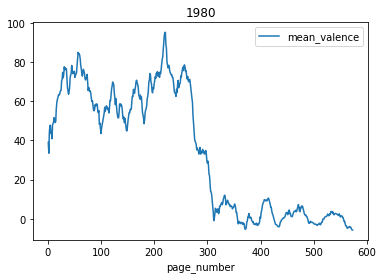

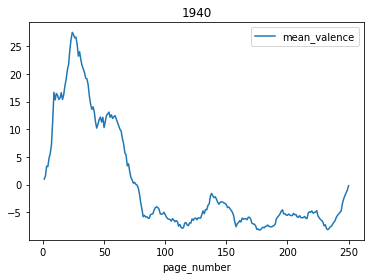

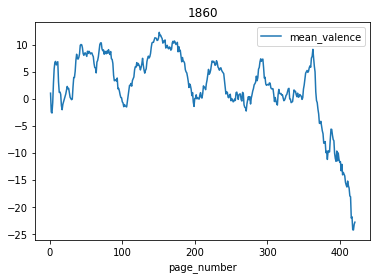

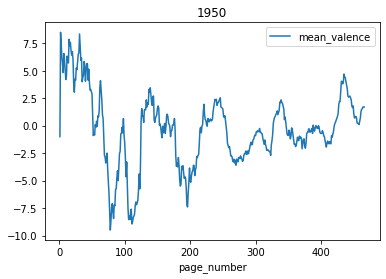

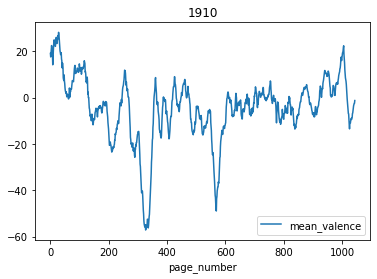

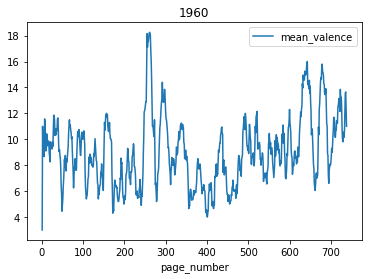

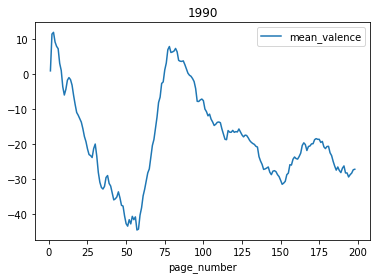

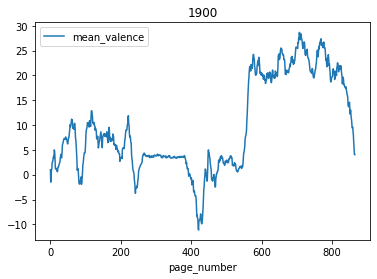

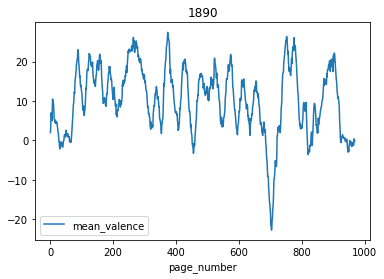

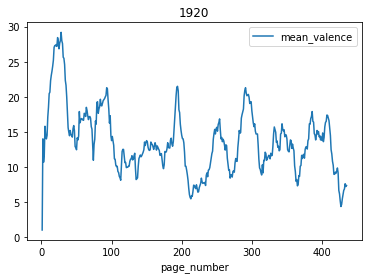

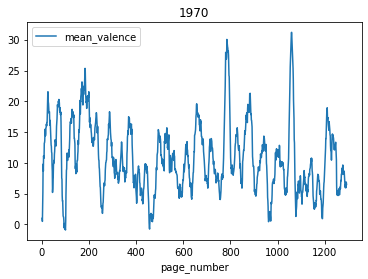

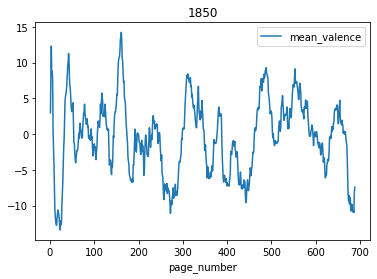

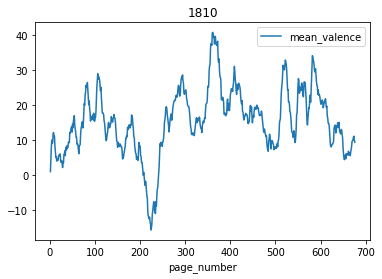

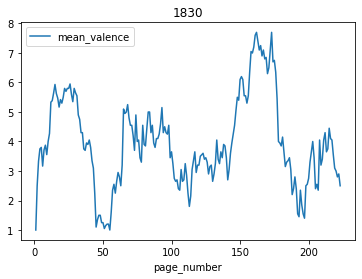

In [ ]:
# Algorithm to plot each of the decades and their mean sentiment as page number increases
for decade in plots:
  plots.get(decade)['page_number'] = range(1, len(plots.get(decade))+1)
  plots.get(decade)['mean_sentiment'] = plots.get(decade)['sentiment_weight'].rolling(20, min_periods=1).mean()
  plots.get(decade).plot(x='page_number',y=['mean_sentiment'], title=decade)

Based on the plots produced, we can see some differences between the progression of sentiment in the average plot for each decade. This will be explored further on the section "Going Forward".

Despite the potential that this program has, it is important to keep in mind a few of its limitations. Most obviously, the results are entirely dependent on the sample passed to the feature reader. This means that any underlying biases or other factors that might undermine how accurately the sample can reflect all the books that it represents will definitely skew the data and make it completely unusable. Due to my lack of expertise, I do not feel confident enough in extracting any conclusions from the data generated.

###InPhO Topic Explorer
This tool is used for topic modelling a particular collection. It uses a machine learning model that generates an interactive visualization which shows the clusters of a collection by topic. We considered providing an interactive implementation through this notebook, but eventually opted with running a sample collection through the instance available at the HTRC webpage. The collection we used is [Action and adventure fiction](https://babel.hathitrust.org/cgi/mb?a=listis&c=1410469188).

The result generated by the topic explorer can be found [here](https://analytics.hathitrust.org/result/ate/287acde2-bfea-44b1-93d0-f4d147e5e5aa/job_results/topics.html). Immediately one can appreciate the usefulness of this tool.

##Underwood Projects

Ted Underwood, Associate Professor of English at the University of Illinois, is one key contributor to digital computation by utilizing computational tools and data sets. Through his fiction project and it’s complimenting article “The Life Cycles of Genres”, Underwood uses sources from the Chicago Text Lab and the HathiTrust Digital Library to collect titles and text from three different fiction categories: Detective fiction, Science fiction, and Gothic. Although Underwood acknowledges that “readers rarely agree about the defining characteristic of a genre”(5), he does note that genre may not be a singular understandable idea, but a set of relations between works. With the assumption that every work can carry genre tags, indications or hints of belonging to a genre(s), Underwood utilizes predictive modeling to compare the different observations readers have on genre. As Underwood states, “I am working with labeled examples, not trying to catched unlabeled ones”(7), his project focuses on pre-established ideas and assumptions and compares these to those formulated by other readers. Through the use of time and these labels, Underwood creates a tool that allows a user to choose 15 different options that vary between the three categories and dates. This tool formulates the number of volumes, amounts missing from the directory and metadata, and the number excluded from the model. Additionally, positive and negative instances are also identified and pointed out. Between each option, the user’s choices compute different results and supply different sets of information. 

It should also be noted that by following Underwood’s program, certain modifications can be made to allow different users to incorporate this tool for their own sets of data. By modifying Underwood’s code, a user will be able to use his methods in ways that guide their understandings and interpretations. 

Underwood’s code is embedded below. Please follow through and read the comments that provide guidance. Please also keep in mind that the corresponding python files should be in the same folder as the Final Project Jupyter Notebook as you run Underwood’s program. 

Here is the link to Underwood's GitHub repository for the fiction project: https://github.com/tedunderwood/fiction


In [ ]:
import logisticpredict, comparemodels
import datetime, sys

In [ ]:
def ghastly_stew():

    ## PATHS.

    sourcefolder = '/mnt/research/courses/dcs1020/fiction-master/newdata/'
    extension = '.fic.tsv'
    metadatapath = '/mnt/research/courses/dcs1020/fiction-master/meta/finalmeta.csv'
    vocabpath = '/mnt/research/courses/dcs1020/fiction-master/lexicon/new10k.csv'

    modelname = 'ghastlystew'
    outputpath = 'results/' + modelname + str(datetime.date.today()) + '.csv'

    # We can simply exclude volumes from consideration on the basis on any
    # metadata category we want, using the dictionaries defined below.

    ## EXCLUSIONS.

    excludeif = dict()
    excludeifnot = dict()
    excludeabove = dict()
    excludebelow = dict()

    excludebelow['firstpub'] = 1700
    excludeabove['firstpub'] = 2020

    allstewgenres = {'cozy', 'hardboiled', 'det100', 'chimyst', 'locdetective', 'lockandkey', 'crime', 'locdetmyst', 'blcrime', 'anatscifi', 'locscifi', 'chiscifi', 'femscifi', 'stangothic', 'pbgothic', 'lochorror', 'chihorror', 'locghost'}

    # We have to explicitly exclude genres because the category "stew" in the
    # positive category wouldn't otherwise automatically exclude the constituent
    # tags that were used to create it.

    # I would just have put all those tags in the positive tag list, but then you'd lose
    # the ability to explicitly balance equal numbers of crime, gothic,
    # and science fiction, plus sensation novels. You'd get a list dominated by
    # the crime categories, which are better-represented in the dataset.

    excludeif['negatives'] = allstewgenres
    sizecap = 250

    # CLASSIFY CONDITIONS

    # We ask the user for a list of categories to be included in the positive
    # set, as well as a list for the negative set. Default for the negative set
    # is to include all the "random"ly selected categories. Note that random volumes
    # can also be tagged with various specific genre tags; they are included in the
    # negative set only if they lack tags from the positive set.

    positive_tags = ['stew']
    negative_tags = ['random', 'chirandom']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    paths = (sourcefolder, extension, metadatapath, outputpath, vocabpath)
    exclusions = (excludeif, excludeifnot, excludebelow, excludeabove, sizecap)
    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

    print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', str(rawaccuracy))

In [ ]:
def make_paths(modelname):
    '''
    Makes a pathtuple using a model name and a default set of
    paths to feature-vocab and metadata files.
    '''

    sourcefolder = '/mnt/research/courses/dcs1020/fiction-master/newdata/'
    extension = '.fic.tsv'
    metadatapath = '/mnt/research/courses/dcs1020/fiction-master/meta/finalmeta.csv'
    vocabpath = '/mnt/research/courses/dcs1020/fiction-master/lexicon/new10k.csv'
    # These words will be used as features

    outputpath = 'results/' + modelname + str(datetime.date.today()) + '.csv'

    return (sourcefolder, extension, metadatapath, outputpath, vocabpath)

In [ ]:
def make_exclusions(startdate, enddate, sizecap, negatives):
    excludeif = dict()
    excludeifnot = dict()
    excludeabove = dict()
    excludebelow = dict()

    excludebelow['firstpub'] = startdate
    excludeabove['firstpub'] = enddate

    if negatives != 'nonegatives':
        excludeif['negatives'] = set(negatives)
    # This is a way to exclude certain tags from the negative contrast set.

    return (excludeif, excludeifnot, excludebelow, excludeabove, sizecap)

In [ ]:
def model_taglist(positive_tags, modelname):
    print('We are modeling these positive tags:')
    for tag in positive_tags:
        print(tag)

    sizecap = 1000
    paths = make_paths(modelname)
    sourcefolder, extension, metadatapath, outputpath, vocabpath = paths

    exclusions = make_exclusions(0, 2000, sizecap, 'nonegatives')

    negative_tags = ['random', 'chirandom']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

    print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', str(rawaccuracy))

    return allvolumes

In [ ]:
def model_taglist_within_dates(positive_tags, modelname, mindate, maxdate):
    print('We are modeling these positive tags:')
    for tag in positive_tags:
        print(tag)

    sizecap = 1000
    paths = make_paths(modelname)
    sourcefolder, extension, metadatapath, outputpath, vocabpath = paths

    exclusions = make_exclusions(mindate, maxdate, sizecap, 'nonegatives')

    negative_tags = ['random', 'chirandom']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

    print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', str(rawaccuracy))

    return allvolumes

In [ ]:
def project_detective_beyond_date(dividedate):

    print('First we create a model of detective fiction only after ' + str(dividedate))

    sizecap = 300

    modelname = 'detectivejustpost' + str(dividedate)
    paths = make_paths(modelname)
    sourcefolder, extension, metadatapath, outputpath1, vocabpath = paths

    exclusions = make_exclusions(dividedate, 2000, sizecap, 'nonegatives')

    positive_tags = ['locdetective', 'locdetmyst', 'chimyst', 'det100']
    negative_tags = ['random', 'chirandom']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

    print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', str(rawaccuracy))
    print()
    print('Then we create a model of detective fiction blindly predicting after ' + str(dividedate))

    modelname = 'detectivepredictpost' + str(dividedate)
    paths = make_paths(modelname)
    sourcefolder, extension, metadatapath, outputpath2, vocabpath = paths

    exclusions = make_exclusions(0, 2001, sizecap, 'nonegatives')

    testconditions = {'1700', str(dividedate)}

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

    print('If we divide the second dataset at 0.5, accuracy is: ', str(rawaccuracy))
    print()

    # Now we compare the predictions made by these two models, comparing only
    # the volumes that are in both models but excluded from the training process
    # in the second model.

    comparemodels.compare_untrained(outputpath1, outputpath2)

In [ ]:
def project_tag_to_another(tagtoproject, tagtarget):

    print('First we create a model of ' + tagtarget)

    sizecap = 400

    modelname = tagtarget + 'byitself'
    paths = make_paths(modelname)
    sourcefolder, extension, metadatapath, outputpath1, vocabpath = paths

    exclusions = make_exclusions(0, 2000, sizecap, tagtoproject)
    # Note that we exclude tagtoproject from the negative contrast set, so the
    # contrast sets for the two models will be identical.

    positive_tags = [tagtarget]
    negative_tags = ['random', 'chirandom']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

    print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', str(rawaccuracy))
    print()
    print('Then we create a model of ' + tagtoproject + ' and use it to predict ' + tagtarget)

    modelname = tagtoproject + 'predicts' + tagtarget
    paths = make_paths(modelname)
    sourcefolder, extension, metadatapath, outputpath2, vocabpath = paths

    exclusions = make_exclusions(0, 2001, sizecap, 'nonegatives')

    positive_tags = [tagtarget, tagtoproject]
    testconditions = {tagtarget}
    # That's the line that actually excludes tagtarget from training.

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

    print('If we divide the second dataset at 0.5, accuracy is: ', str(rawaccuracy))
    print()

    # Now we compare the predictions made by these two models, comparing only
    # the volumes that are in both models but excluded from the training process
    # in the second model.

    comparemodels.compare_untrained(outputpath1, outputpath2)

In [ ]:
def project_tags(tagstoproject, tagtargets):

    targetstring = ','.join(tagtargets)
    projectstring = ','.join(tagstoproject)

    print('First we create a model of ' + targetstring)

    sizecap = 400

    modelname = targetstring + 'byitself'
    paths = make_paths(modelname)
    sourcefolder, extension, metadatapath, outputpath1, vocabpath = paths

    exclusions = make_exclusions(0, 2000, sizecap, tagstoproject)
    # Note that we exclude tagstoproject from the negative contrast set, so the
    # contrast sets for the two models will be identical.

    positive_tags = tagtargets
    negative_tags = ['random', 'chirandom']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

    print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', str(rawaccuracy))
    print()
    print('Then we create a model of ' + projectstring + ' and use it to predict ' + targetstring)

    modelname = projectstring + 'predicts' + targetstring
    paths = make_paths(modelname)
    sourcefolder, extension, metadatapath, outputpath2, vocabpath = paths

    exclusions = make_exclusions(0, 2000, sizecap, 'nonegatives')

    positive_tags = list(tagtargets)
    positive_tags.extend(tagstoproject)
    testconditions = set(tagtargets)
    # That's the line that actually excludes tagtarget from training.

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

    print('If we divide the second dataset at 0.5, accuracy is: ', str(rawaccuracy))
    print()

    # Now we compare the predictions made by these two models, comparing only
    # the volumes that are in both models but excluded from the training process
    # in the second model.

    comparemodels.compare_untrained(outputpath1, outputpath2)

In [ ]:
def the_red_and_the_black():

    sizecap = 140

    modelname = 'blackandthered'
    paths = make_paths(modelname)

    exclusions = make_exclusions(1700, 2001, sizecap, 'nonegatives')

    positive_tags = ['teamred']
    negative_tags = ['teamblack']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    accuracies = []
    for i in range(40):

        modelname = 'redandtheblack' + str(i)
        paths = make_paths(modelname)

        rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)
        print(rawaccuracy)
        accuracies.append(rawaccuracy)

    with open('finalaccuracies.csv', mode = 'w', encoding = 'utf-8') as f:
        for accuracy in accuracies:

In [ ]:
def replicate_stew():

    sizecap = 140

    modelname = 'replicatestew'
    paths = make_paths(modelname)

    ## EXCLUSIONS.

    excludeif = dict()
    excludeifnot = dict()
    excludeabove = dict()
    excludebelow = dict()

    excludebelow['firstpub'] = 1700
    excludeabove['firstpub'] = 2020

    allstewgenres = {'cozy', 'hardboiled', 'det100', 'chimyst', 'locdetective', 'lockandkey', 'crime', 'locdetmyst', 'blcrime', 'anatscifi', 'locscifi', 'chiscifi', 'femscifi', 'stangothic', 'pbgothic', 'lochorror', 'chihorror', 'locghost'}

    # We have to explicitly exclude genres because the category "stew" in the
    # positive category wouldn't otherwise automatically exclude the constituent
    # tags that were used to create it.

    # I would just have put all those tags in the positive tag list, but then you'd lose
    # the ability to explicitly balance equal numbers of crime, gothic,
    # and science fiction, plus sensation novels. You'd get a list dominated by
    # the crime categories, which are better-represented in the dataset.

    excludeif['negatives'] = allstewgenres
    exclusions = (excludeif, excludeifnot, excludebelow, excludeabove, sizecap)

    positive_tags = ['stew']
    negative_tags = ['random', 'chirandom']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    accuracies = []
    for i in range(20):

        rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)
        print(rawaccuracy)
        accuracies.append(rawaccuracy)

    with open('stewaccuracies.csv', mode = 'a', encoding = 'utf-8') as f:
        for accuracy in accuracies:
            f.write(str(accuracy) + '\n')

In [ ]:
def replicate_detective():

    sizecap = 140

    modelname = 'replicatedet'
    paths = make_paths(modelname)

    ## EXCLUSIONS.

    excludeif = dict()
    excludeifnot = dict()
    excludeabove = dict()
    excludebelow = dict()

    excludebelow['firstpub'] = 1700
    excludeabove['firstpub'] = 2020


    # We have to explicitly exclude genres because the category "stew" in the
    # positive category wouldn't otherwise automatically exclude the constituent
    # tags that were used to create it.

    # I would just have put all those tags in the positive tag list, but then you'd lose
    # the ability to explicitly balance equal numbers of crime, gothic,
    # and science fiction, plus sensation novels. You'd get a list dominated by
    # the crime categories, which are better-represented in the dataset.

    exclusions = (excludeif, excludeifnot, excludebelow, excludeabove, sizecap)

    positive_tags = ['locdetective', 'locdetmyst', 'chimyst', 'locdetmyst', 'det100']
    negative_tags = ['random', 'chirandom']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    accuracies = []
    for i in range(20):

        rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)
        print(rawaccuracy)
        accuracies.append(rawaccuracy)

    with open('detaccuracies.csv', mode = 'a', encoding = 'utf-8') as f:
        for accuracy in accuracies:
            f.write(str(accuracy) + '\n')

In [ ]:
def calibrate_detective():
    '''
    Tests accuracy of classification for detective fiction at different sample
    sizes.
    '''

    modelname = 'calibratedet'
    paths = make_paths(modelname)

    ## EXCLUSIONS.

    excludeif = dict()
    excludeifnot = dict()
    excludeabove = dict()
    excludebelow = dict()

    excludebelow['firstpub'] = 1700
    excludeabove['firstpub'] = 2020


    positive_tags = ['locdetective', 'locdetmyst', 'chimyst', 'locdetmyst', 'det100']
    negative_tags = ['random', 'chirandom']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    sizes = [5,6,7,8,9,11,13,15,17,18,21,27,29,32,34,36,40,45,50,55,60,65,70,75,80,85,90,100]

    # with open('../results/collateddetectiveaccuracies.tsv', mode = 'a', encoding = 'utf-8') as f:
    #         f.write('sizecap\tavgsize\trawaccuracy\n')

    accuracies = []
    for sizecap in sizes:

        exclusions = (excludeif, excludeifnot, excludebelow, excludeabove, sizecap)

        rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

        trainsizes = []
        for vol in allvolumes:
            trainsizes.append(vol[11])
            # this is unfortunately dependent on the exact way
            # logisticpredict formats its output

        avgsize = sum(trainsizes) / len(trainsizes)

        print(sizecap, avgsize, rawaccuracy)
        with open('collateddetaccuracies.tsv', mode = 'a', encoding = 'utf-8') as f:
            f.write(str(sizecap) + '\t' + str(avgsize) + '\t' + str(rawaccuracy) + '\n')

    return None

In [ ]:
def calibrate_stew():
    '''
    Tests accuracy of classification for ghastly stew at different sample
    sizes.
    '''

    modelname = 'calibratestew'
    paths = make_paths(modelname)

    ## EXCLUSIONS.

    excludeif = dict()
    excludeifnot = dict()
    excludeabove = dict()
    excludebelow = dict()

    excludebelow['firstpub'] = 1700
    excludeabove['firstpub'] = 2020


    allstewgenres = {'cozy', 'hardboiled', 'det100', 'chimyst', 'locdetective', 'lockandkey', 'crime', 'locdetmyst', 'blcrime', 'anatscifi', 'locscifi', 'chiscifi', 'femscifi', 'stangothic', 'pbgothic', 'lochorror', 'chihorror', 'locghost'}

    # We have to explicitly exclude genres because the category "stew" in the
    # positive category wouldn't otherwise automatically exclude the constituent
    # tags that were used to create it.

    # I would just have put all those tags in the positive tag list, but then you'd lose
    # the ability to explicitly balance equal numbers of crime, gothic,
    # and science fiction, plus sensation novels. You'd get a list dominated by
    # the crime categories, which are better-represented in the dataset.

    excludeif['negatives'] = allstewgenres

    positive_tags = ['stew']
    negative_tags = ['random', 'chirandom']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    sizes = [5,6,7,8,9,11,13,15,17,18,21,27,29,32,34,36,40,45,50,55,60,65,70,75,80,85,90,100]

    # with open('../results/collatedstewaccuracies.tsv', mode = 'a', encoding = 'utf-8') as f:
    #         f.write('sizecap\tavgsize\trawaccuracy\n')

    accuracies = []
    for sizecap in sizes:

        exclusions = (excludeif, excludeifnot, excludebelow, excludeabove, sizecap)

        rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

        trainsizes = []
        for vol in allvolumes:
            trainsizes.append(vol[11])
            # this is unfortunately dependent on the exact way
            # logisticpredict formats its output

        avgsize = sum(trainsizes) / len(trainsizes)

        print(sizecap, avgsize, rawaccuracy)
        with open('collatedstewaccuracies.tsv', mode = 'a', encoding = 'utf-8') as f:
            f.write(str(sizecap) + '\t' + str(avgsize) + '\t' + str(rawaccuracy) + '\n')

    return None

In [ ]:
def project_gothic_beyond_date(dividedate):

    print('First we create a model of gothic fiction only after ' + str(dividedate))

    sizecap = 300

    modelname = 'gothicjustpost' + str(dividedate)
    paths = make_paths(modelname)
    sourcefolder, extension, metadatapath, outputpath1, vocabpath = paths

    exclusions = make_exclusions(dividedate, 2000, sizecap, 'nonegatives')

    positive_tags = ['lochorror', 'pbgothic', 'locghost', 'stangothic', 'chihorror']
    negative_tags = ['random', 'chirandom']
    testconditions = set()

    datetype = "firstpub"
    numfeatures = 10000
    regularization = .000075

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

    print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', str(rawaccuracy))
    print()
    print('Then we create a model of gothic fiction blindly predicting after ' + str(dividedate))

    modelname = 'gothicpredictpost' + str(dividedate)
    paths = make_paths(modelname)
    sourcefolder, extension, metadatapath, outputpath2, vocabpath = paths

    exclusions = make_exclusions(0, 2001, sizecap, 'nonegatives')

    testconditions = {'1700', str(dividedate)}

    classifyconditions = (positive_tags, negative_tags, datetype, numfeatures, regularization, testconditions)

    rawaccuracy, allvolumes, coefficientuples = logisticpredict.create_model(paths, exclusions, classifyconditions)

    print('If we divide the second dataset at 0.5, accuracy is: ', str(rawaccuracy))
    print()

    # Now we compare the predictions made by these two models, comparing only
    # the volumes that are in both models but excluded from the training process
    # in the second model.

    comparemodels.compare_untrained(outputpath1, outputpath2)

In the following code cell, we see print commands and if statements that determine what the end results of this code are. In addition, depending on the option chosen, the program will ask for different types of information.


In [ ]:
if __name__ == '__main__':

    # args = sys.argv

    print('Your options include: ')
    print('  1) Model Indiana detective fiction by itself.')
    print('  2) Model LOC detective-esque categories by themselves.')
    print('  3) Model LOC and Indiana together.')
    print('  4) Extrapolate a model of LoC detective fiction to the Indiana exhibition.')
    print('  5) Extrapolate a model of detective fiction beyond a particular date.')
    print('  6) Extrapolate a model of one arbitrary genre tag to another.')
    print('  7) Extrapolate a model of gothic fiction beyond a particular date.')
    print('  8) Extrapolate a model of several tags to several others.')
    print('  9) Run detective prediction at many different sizes.')
    print('  10) Run ghastly stew prediction at many different sizes.')
    print('  11) Try to use detective fiction to predict scifi (fails).')
    print('  12) Model an arbitrary tag against random control set.')
    print('  13) Model all early gothic 1760-1840.')
    print('  14) Model all gothic.')
    print('  15) Model all SF.')

    userchoice = int(input('\nyour choice: '))

    if userchoice == 1:
        tagstomodel = ['det100']
        modelname = 'IndianaDetective'
        allvolumes = model_taglist(tagstomodel, modelname)
        print('Results are in allvolumes.')
    elif userchoice == 2:
        tagstomodel = ['locdetmyst', 'locdetective', 'chimyst']
        modelname = 'LOCdetective'
        allvolumes = model_taglist(tagstomodel, modelname)
        print('Results are in allvolumes.')
    elif userchoice == 3:
        tagstomodel = ['det100', 'locdetmyst', 'locdetective', 'chimyst']
        modelname = 'AllDetective'
        allvolumes = model_taglist(tagstomodel, modelname)
        print('Results are in allvolumes.')
    elif userchoice == 4:
        tagtoproject = ['locdetmyst', 'locdetective', 'chimyst']
        tagtarget = ['det100']
        project_tags(tagtoproject, tagtarget)
    elif userchoice == 5:
        dividedate = int(input('date beyond which to project: '))
        project_detective_beyond_date(dividedate)
    elif userchoice == 6:
        tagtoproject = input('tag to project from: ')
        tagtarget = input('tag to project onto: ')
        project_tag_to_another(tagtoproject, tagtarget)
    elif userchoice == 7:
        dividedate = int(input('date beyond which to project: '))
        project_gothic_beyond_date(dividedate)
    elif userchoice == 8:
        tagstoproject = input('comma-separated list of tags to model and project from: ')
        tagstoproject = [x.strip() for x in tagstoproject.split(',')]
        tagtargets = input('comma-separated list of tags project onto: ')
        tagtargets = [x.strip() for x in tagtargets.split(',')]
        project_tags(tagstoproject, tagtargets)
    elif userchoice == 9:
        calibrate_detective()
    elif userchoice == 10:
        calibrate_stew()
    elif userchoice == 11:
        projectfrom = 'chimyst'
        projectonto = 'chiscifi'
        project_tag_to_another(projectfrom, projectonto)
    elif userchoice == 12:
        tagtomodel = input('tag to model (must be in metadata)? ')
        tagstomodel = [tagtomodel]
        allvolumes = model_taglist(tagstomodel, tagtomodel)
    elif userchoice == 13:
        tagstomodel = ['stangothic', 'pbgothic', 'lochorror', 'locghost']
        allvolumes = model_taglist_within_dates(tagstomodel, 'EarlyGothic', 1760, 1840)
    elif userchoice == 14:
        tagstomodel = ['stangothic', 'pbgothic', 'lochorror', 'locghost', 'chihorror']
        modelname = 'AllGothic'
        allvolumes = model_taglist(tagstomodel, modelname)
        print('Results are in allvolumes.')
    elif userchoice == 15:
        tagstomodel = ['locscifi', 'femscifi', 'anatscifi', 'chiscifi']
        modelname = 'AllSF'
        allvolumes = model_taglist(tagstomodel, modelname)
        print('Results are in allvolumes.')

    print('Done.')

The following visual showcases an end result of the code when and if the user chooses option 1. As we can see, the previous code cells are performed and once the last code cell is run, the results are all displayed due to the print commands. As shown, the amount of volumes in the metadata, the number missing in the directory, and the number of positive and negative instances within the data are all displayed when option 1 is selected.

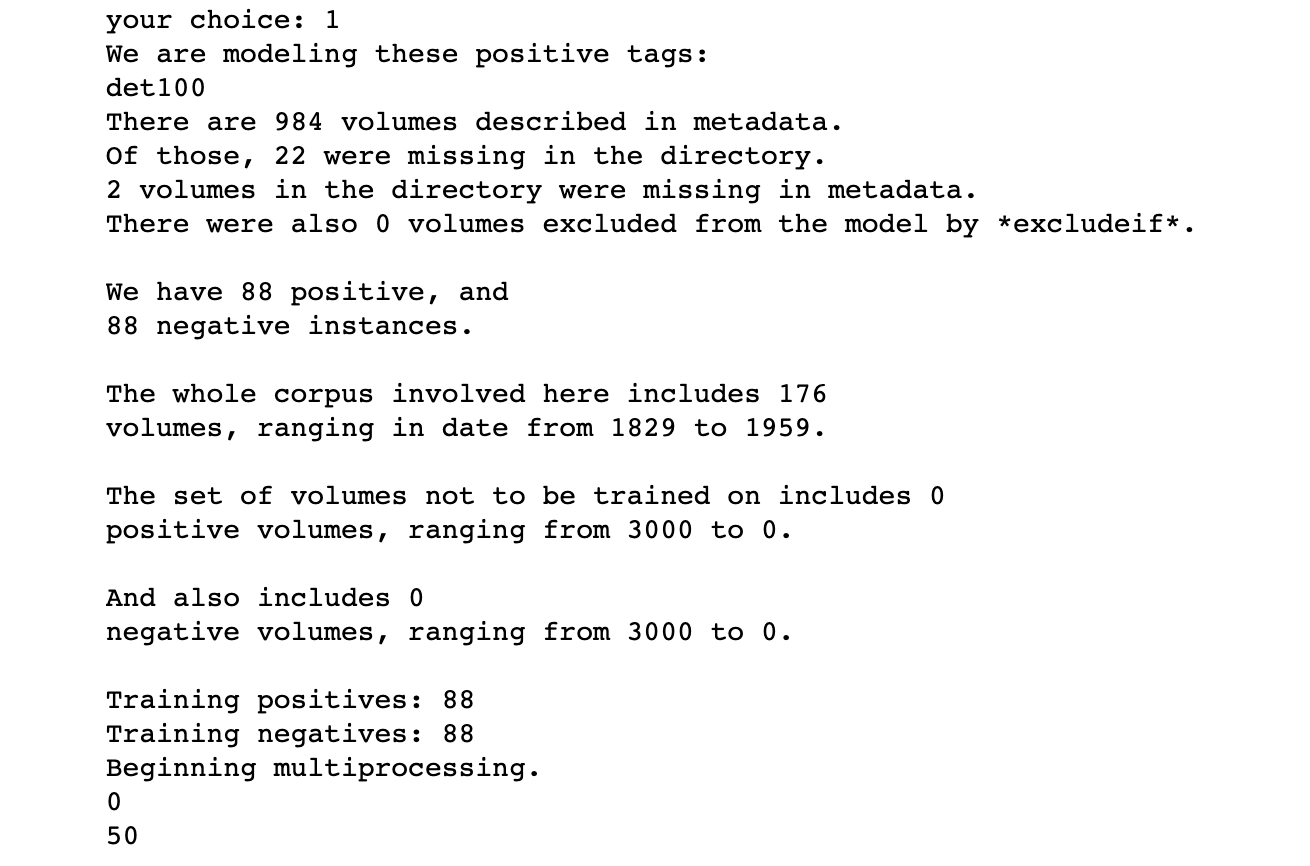

To continue on Underwood's research, he also has a project titled “Genre Project” as a repository in his GitHub. The data used for this project is generated from the full texts of all public-domain English-language works in HathiTrust between 1700 and 1972. By using these texts, the word counts and other details of the page structures are used in the process of Underwood’s “Genre Project” computational tool.

Here is the link to his repository: https://github.com/tedunderwood/GenreProject

Please also consider referencing Underwood’s complimenting article “Understanding Genre in a Million Volumes” for further explanations.


##Going Forward

Going forward we wanted to see if we could come up with some more tools inorder to expand on the computation. For example, there is one thing in specific I wanted to look at which was influenced by an idea that was offered at the end of the book *Uncharted* by Erez Aiden and Jean-Baptiste Michel. The book was mostly about google ngrams and how you can use that tool to look at cultural trends and stuff. In the end they introduced the idea of Psychohistory or calculating how society will change in the future. They also introduced the idea of "cultural inertia" with looking at the ngram trends and said, "Ngrams in motion tend to stay in motion (unless acted on by a psychohistorical force)" (Aiden, Michel 211). So I thought it would be cool to see if you could find relationships between ngrams and use those to model how the trends would play out in the future.

I soon realized this would not be a very good experiment after another reading we did later in the semester. In an article by Dan Cohen called “Searching for the Victorians,” he briefly talked about trends that looked similar but had no connection. He found that the words “belief,” “atheism,” and “Aristotle” were found at a relatively similar frequency amongst books published during that period (CITATION). However, you can’t really say that all of those terms are related somehow because of this because you don’t have enough information, it could just be coincidences. This means that it is hard to use this kind of data to predict trends just on the relationships between two trends because you don’t know to what degree they are actually related.

However, this doesn’t mean that finding correlated trends isn’t completely useless. In an article called “History and the ‘Pre’,” Daniel Lord Smail and Andrew Shyrock investigate the “modernity” and its use in the historical community and society. One thing they were able to show how connected the terms “modernity” and “Premodern” were by showing the similarities in their trends (CITATION). While like in the previous article, you can’t just say look at the two trends and say they are related, the two trends do help supplement other information showing the relationship between the trends. All of this motivated me to try to quickly come up with some code to help look how similar two trends are. I thought this would be a cool example of how to take the methods we talked about further.

What I am writing here are essentially three basic functions that can help look at the correlation of two trends. They will look at: the difference between each graph, the difference between the two graphs derivatives, and the differences between the first graph’s derivative and the second graphs negative derivative.

The first function takes in two numpy arrays that each correspond to respective graphs. It then uses a for loop to find the difference between each set of two points that correspond to each other on the graphs. After that it squares this difference in order to optimize for graphs that are more uniformly similar instead of similar on average (for example if one graph went 2,4 and the other went 2,8, without squaring the difference would be the same as if the graphs went 2,4 and 4,6. However, if you square it then 2,4 and 2,8 yields a value of 16 whereas 2,4 and 4,6 yields a value of 8.)

In [ ]:
#this is the first function, it just takes two numpy arrays and sums up the difference squared between them
def getDif(dataOne, dataTwo):
    dif = 0
    #this goes thorugh every value in the arrays
    #finds the differences squared (for the reason I mentioned in the block above)
    #and then adds it to the variable dif which just holds the sum
    for x in range(dataOne.size):
        dif= dif + ((dataOne.item(x)-dataTwo.item(x))**2)
    return dif

The second function also takes in two numpy arrays and then approximates two more numpy arrays that correspond to the derivatives of the two graphs. Then it finds the difference between the two arrays in a similar way as the first function. This lets us check if two graphs have similar behaviors regardless of how similar the actual numbers on the graph are.

In [ ]:
#this is similar to the first function but it finds the difference between the derivatives
def getDerDif(dataOne, dataTwo):
    #first thing I do is take each array and create a array with th
    derOne = np.array([0])
    #this approximates the derivative by just caluclating the slope between each points
    #which is just the value in the array minus the previous value
    for x in range(1, dataOne.size):
        derOne = np.append(derOne,dataOne.item(x)-dataOne.item(x-1))
    derTwo = np.array([0])
    for x in range(1, dataTwo.size):
        derTwo = np.append(derTwo,dataTwo.item(x)-dataTwo.item(x-1))
    #this then uses the two derivative arrays and plugs it into the first function
    dif = getDif(derOne,derTwo)
    return dif

The last function does the same thing as the second function but looks at the negative derivative of the second graph. This can maybe show an inverse relationship in behavior.

In [ ]:
#this last function just finds out if the derivatives are inversely related
#it is the exact same except for the second array it multiplies the slope by negative one
def getNegativeDerDif(dataOne, dataTwo):
    derOne = np.array([0])
    for x in range(1, dataOne.size):
        derOne = np.append(derOne,dataOne.item(x)-dataOne.item(x-1))
    derTwo = np.array([0])
    for x in range(1, dataTwo.size):
        derTwo = np.append(derTwo,-1*(dataTwo.item(x)-dataTwo.item(x-1)))
    dif = getDif(derOne,derTwo)
    return dif

Below I am making some basic arrays. Feel free to change them around and play with the functions in order to better understand how they work.

In [ ]:
a = np.array([1,3,5,7,9,11,13,15,17,20])   
b = np.array([2,4,6,7,10,12,14,16,18,20]) 
c = np.array([-2,-4,-6,-7,-10,-12,-14,-16,-18,-20])
d = np.array([1,1,2,3,5,8,13,21,34,55])

Below you can run the functions and print out the results however you want, I have called each function with the parameters a and b but feel free to change the parameters and run them again.

In [ ]:
print(getDif(a,b))
print(getDerDif(a,b))
print(getNegDerDif(a,b))

8
3
155


Now that we have tested the functions out a bit, I want to see if we can take some of the data from above and plug it into these functions. Here I am taking the data of the sentiment trends, converting them to numpy arrays, and creating arrays of just the mean_valence. Feel free to change the decade found in the for loop if you want to play with it.

In [ ]:

firstTest = np.array([])
secondTest = np.array([])
for x in range(200):
  firstTest = np.append(firstTest,plots.get(1980)['mean_valence'].to_numpy().item(x))
  secondTest = np.append(secondTest,plots.get(1950)['mean_valence'].to_numpy().item(x))


Finally, I am plugging in these arrays into my function.

In [ ]:
print(getDif(firstTest,secondTest))
print(getDerDif(firstTest,secondTest))
print(getNegDerDif(firstTest,secondTest))

799004.6436566933
1588.3830869264475
1483.4908485647823


CONCLUSION- Also comment code above!

#Bibliography
- Jacob Jett, Boris Capitanu, Deren Kudeki, Timothy Cole, Yuerong Hu, Peter Organisciak, Ted Underwood, Eleanor Dickson Koehl, Ryan Dubnicek, J. Stephen Downie (2020). The HathiTrust Research Center Extracted Features Dataset (2.0).HathiTrust Research Center.https://doi.org/10.13012/R2TE-C227

- Jaimie Murdock and Colin Allen. (2015) Visualization Techniques for Topic Model Checking in Proceedings of the 29th AAAI Conference on Artificial Intelligence (AAAI-15). Austin, Texas, USA, January 25-29, 2015. https://hypershelf.org/



#Writing Reflections
- Juan Atehortúa: